In [442]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from collections import Counter
from sklearn.metrics import f1_score, recall_score, roc_auc_score, auc, precision_recall_curve

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


In [443]:
df = pd.read_csv("Datos_regresion.csv") # read in data downloaded to the local directory
df.head()

,Edad,Diag.Ing1,Diag.Ing2,Diag.Egr1,Diag.Egr2,APACHE,TiempoVAM,Fallece
0,35,1,0,1,0,10,2,0
1,87,2,0,2,0,16,2,0
2,70,4,0,4,0,11,2,0
3,24,13,0,13,5,11,2,0
4,24,3,0,3,0,17,3,0


In [444]:
# # Se crea un nuevo dataset con los datos de forma tal que puedan ser procesados por el algoritmo
# df_new = df[["Edad", "APACHE", "TiempoVAM"]]
# lista = ["Diag.Ing1", "Diag.Ing2", "Diag.Egr1", "Diag.Egr2"]
# for i in lista:
#     new = pd.get_dummies(df[i], prefix=i)
#     df_new = pd.concat([df_new , new], axis = 1)
# df_new = pd.concat([df_new , df.Fallece], axis =1)
# df = df_new
# df.head()

In [445]:
# Tomamos un dato para predecir su probabilidad de morir
x_pred_f = df.loc[df.Fallece == 1]
x_pred_f = x_pred_f[1:2]
x_pred_f = x_pred_f.drop("Fallece", axis =1)

In [446]:
# Tomamos un dato para predecir su probabilidad de vivir
x_pred_v = df.loc[df.Fallece == 0]
x_pred_v = x_pred_v[:1]
x_pred_v = x_pred_v.drop("Fallece", axis =1)

In [447]:
print(df.shape)
print(pd.value_counts(df['Fallece'], sort = True))

(208, 8)
Fallece
0    176
1     32
Name: count, dtype: int64


C:\Users\anportal\AppData\Local\Temp\ipykernel_11616\1983737910.py:2: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.



C:\Users\anportal\AppData\Local\Temp\ipykernel_11616\545876988.py:1: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.



Text(0, 0.5, 'Number of Observations')

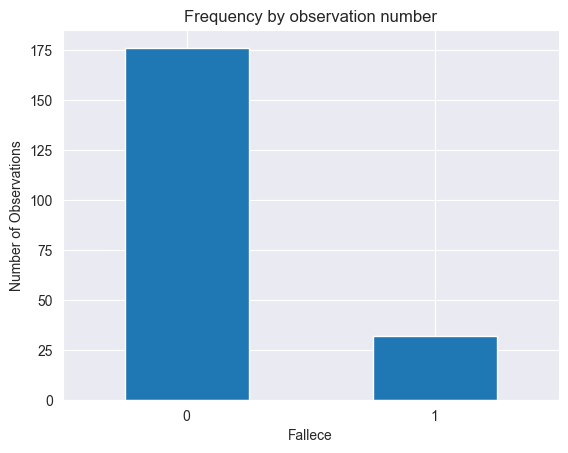

In [448]:
count_classes = pd.value_counts(df['Fallece'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2))
plt.title("Frequency by observation number")
plt.xlabel("Fallece")
plt.ylabel("Number of Observations")

In [449]:
#definimos nuestras etiquetas y features
y = df['Fallece']
X = df.drop('Fallece', axis=1)

# Random Over Sampling

In [450]:
# Se realiza el OVerSampling
os =  RandomOverSampler(random_state=42)
X_train_res, y_train_res = os.fit_resample(X, y)
print ("Distribution before resampling {}".format(Counter(y)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 176, 1: 32})
Distribution labels after resampling Counter({0: 176, 1: 176})


# Set split

In [451]:
# Dividir los datos en conjunto de entrenamiento + validación y conjunto de prueba
X_train, X_test_val, y_train, y_test_val = train_test_split(X_train_res, y_train_res, train_size=0.8, random_state=42)

# Dividir el conjunto de entrenamiento + validación en conjunto de entrenamiento y conjunto de validación
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

In [452]:
print("Tamaño del conjunto de entrenamiento:", len(X_train))
print("Tamaño del conjunto de validación:", len(X_val))
print("Tamaño del conjunto de prueba:", len(X_test))

Tamaño del conjunto de entrenamiento: 281
Tamaño del conjunto de validación: 36
Tamaño del conjunto de prueba: 35


# KNN

In [453]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
    'p': [1, 2]
}

# Configurar la búsqueda en cuadrícula
clf = GridSearchCV( KNeighborsClassifier(), param_grid, scoring='f1', cv=5)
clf.fit(X_val, y_val)

# Obtener los mejores parámetros
best_params = clf.best_params_
# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:")
print(best_params)



KeyboardInterrupt: 

In [ ]:
# Crear un nuevo modelo con los mejores hiperparámetros encontrados
best_knn_model = KNeighborsClassifier(**best_params)

# Entrenar el modelo con el conjunto de datos completo de entrenamiento + validación
best_knn_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_knn_model.predict(X_test)

In [ ]:
targets=[1,0]

recall = recall_score(y_test, y_pred, labels=targets, average=None)
print("Recall Score:", recall)

f1 = f1_score(y_test, y_pred, labels=targets, average=None)
print("F1 Score:", f1)

# Calcular AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred, average=None)
print("AUC-ROC:", auc_roc)

# precision, recall, _ = precision_recall_curve(y_test, y_scores)
# auc_pr = auc(recall, precision)
# print("AUC-PR:", auc_pr)

In [ ]:
print (classification_report(y_test, y_pred))

# Logistic Regression

In [ ]:


param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': [ 'l1', 'l2', None]
}

# Configurar la búsqueda en cuadrícula
clf = GridSearchCV(LogisticRegression(), param_grid, scoring='f1', cv=5)
clf.fit(X_val, y_val)


# Obtener los mejores parámetros
best_params = clf.best_params_
# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:")
print(best_params)

In [ ]:
# Crear un nuevo modelo con los mejores hiperparámetros encontrados
best_lr_model = LogisticRegression(**best_params)

# Entrenar el modelo con el conjunto de datos completo de entrenamiento + validación
best_lr_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_lr_model.predict(X_test)

In [ ]:
# Resultado del algorimo: [probabilidad de que viva: probabilidad de que muera]
prob = clf.predict_proba(X)
np.savetxt("prob.csv", prob, delimiter=',')

In [ ]:
# Resultado del algorimo: [probabilidad de que viva: probabilidad de que muera]
prob = clf.predict_proba(x_pred_v)
prob

In [ ]:
# Metricas
val_mae = mean_absolute_error(y_test , y_pred)
print("Validation MAE: {}".format(val_mae))

val_mse = mean_squared_error(y_test , y_pred)
print("Validation MSE: {}".format(val_mse))

val_rmse = mean_squared_error(y_test , y_pred, squared=False)
print("Validation RMSE: {}".format(val_rmse))

In [ ]:
targets=[1,0]

recall = recall_score(y_test, y_pred, labels=targets, average=None)
print("Recall Score:", recall)

f1 = f1_score(y_test, y_pred, labels=targets, average=None)
print("F1 Score:", f1)

# Calcular AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred, average=None)
print("AUC-ROC:", auc_roc)

# precision, recall, _ = precision_recall_curve(y_test, y_scores)
# auc_pr = auc(recall, precision)
# print("AUC-PR:", auc_pr)



In [ ]:
# Cross Validation
print(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())

# MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score


# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'hidden_layer_sizes': [(50,), (50, 50), (30, 30), (100,) ],
    'activation': ['logistic', 'relu', 'tanh'],
    'solver': ['adam', 'sgd','lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [ 200, 300, 400],
}

# Crear el objeto GridSearchCV con balanced_accuracy como métrica
mlp = GridSearchCV(MLPClassifier(random_state=42), param_grid, cv=5, scoring='f1', n_jobs=-1)

# Ajustar el modelo al conjunto de entrenamiento
mlp.fit(X_val, y_val)

# Obtener los mejores hiperparámetros
best_params = mlp.best_params_
print("Mejores hiperparámetros:", best_params)

# Predecir en el conjunto de prueba con el modelo ajustado
#y_pred = mlp.predict(X_test)

# Calcular la precisión balanceada en el conjunto de prueba
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Precisión balanceada en el conjunto de prueba:", balanced_accuracy)

In [ ]:
best_mlp_model = MLPClassifier(**best_params, random_state=42)

best_mlp_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba con el modelo ajustado
y_pred = best_mlp_model.predict(X_test)

In [ ]:

# Metricas
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred, squared=False)}")

In [ ]:
targets=[1,0]

recall = recall_score(y_test, y_pred, labels=targets, average=None)
print("Recall Score:", recall)

f1 = f1_score(y_test, y_pred, labels=targets, average=None)
print("F1 Score:", f1)

# Calcular AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred, average=None)
print("AUC-ROC:", auc_roc)

# precision, recall, _ = precision_recall_curve(y_test, y_scores)
# auc_pr = auc(recall, precision)
# print("AUC-PR:", auc_pr)

In [ ]:
# cv_scores = cross_val_score(mlp, X, y, cv=10, scoring='neg_mean_squared_error')
# print(cv_scores)

# LIME

In [460]:
# Obtener la primera instancia de X_test
prediccion = best_mlp_model.predict(X_test[:1])

print(prediccion)

print(y_test[:1])

[0]
155    0
Name: Fallece, dtype: int64


In [461]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from interpret import show
from interpret.blackbox import LimeTabular

In [462]:
lime = LimeTabular(best_mlp_model, X_train)

explanation = lime.explain_local(X_test[:1], y_test[:1])


show(explanation)